In [1]:
from collections.abc import Iterable
from copy import deepcopy
from random import randint, choice
from typing import List

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from tqdm.notebook import trange, tqdm

from graph import create_graph, milp_solve, milp_solve_mds, mdsi, clustering_coefficient, \
    jaccard_coefficient
from pyg import geom_data

In [2]:
figsize = (15, 6)

In [3]:
ckp_path = './experiments/2024-09-26 2001/0/checkpoints/epoch=266-step=213599.ckpt'
checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
hyper_parameters = checkpoint['hyper_parameters']

use_clustering_coefficient = False
use_jaccard_coefficient = False

solver = milp_solve_mds
indexer = mdsi

dataset = './experiments/2024-09-25 2140/dataset'
train_test_index = './experiments/2024-09-26 2001'

n, p = 200, .25

In [45]:
graphs: List[geom_data.Data] = []
if dataset:
    _, test_index = torch.load(f'{train_test_index}/0_train_test_idx.pt')
    graphs = [torch.load(f'{dataset}/{i}.pt') for i in tqdm(test_index, unit='graph')]

  0%|          | 0/2000 [00:00<?, ?graph/s]

In [5]:
from models import GNNModel

state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
state_dict.pop('loss_module.pos_weight', None)
# k = k.replace('.weight', '.lin.weight').replace('model.', '')
# if 'output_layers' in k:
#     v = v.T
# if k == 'layers.0.lin.weight':
#     v = v.T

gnn = GNNModel(c_in=hyper_parameters['c_in'], c_hidden=30, c_out=hyper_parameters['c_out'], num_layers=hyper_parameters['num_layers'],
               m=hyper_parameters['m'], dp_rate=hyper_parameters.get('dp_rate'))
gnn.load_state_dict(state_dict)
gnn.eval()
gnn

GNNModel(
  (layers): ModuleList(
    (0): GCNConv(1, 30)
    (1): ReLU(inplace=True)
    (2): GCNConv(30, 30)
    (3): ReLU(inplace=True)
    (4): GCNConv(30, 30)
    (5): ReLU(inplace=True)
    (6): GCNConv(30, 30)
    (7): ReLU(inplace=True)
    (8): GCNConv(30, 30)
    (9): ReLU(inplace=True)
    (10): GCNConv(30, 30)
    (11): ReLU(inplace=True)
    (12): GCNConv(30, 30)
    (13): ReLU(inplace=True)
    (14): GCNConv(30, 30)
    (15): ReLU(inplace=True)
    (16): GCNConv(30, 30)
    (17): ReLU(inplace=True)
    (18): GCNConv(30, 30)
    (19): ReLU(inplace=True)
    (20): GCNConv(30, 30)
    (21): ReLU(inplace=True)
    (22): GCNConv(30, 30)
    (23): ReLU(inplace=True)
    (24): GCNConv(30, 30)
    (25): ReLU(inplace=True)
    (26): GCNConv(30, 30)
    (27): ReLU(inplace=True)
    (28): GCNConv(30, 30)
    (29): ReLU(inplace=True)
    (30): GCNConv(30, 30)
    (31): ReLU(inplace=True)
    (32): GCNConv(30, 30)
    (33): ReLU(inplace=True)
    (34): GCNConv(30, 30)
    (35): ReLU(i

In [6]:
def get_x(g, n):
    idx_t = torch.Tensor([[i] for i in range(n)])
    x = clustering_coefficient(g)[:, 1].unsqueeze(1) if use_clustering_coefficient else torch.Tensor([[1.]]*n)
    if use_jaccard_coefficient:
        jc = jaccard_coefficient(g, n, 8)
        x = torch.cat((x, jc), 1)
    return torch.cat([idx_t, x], dim=1)

In [20]:
if graphs:
    tg = choice(graphs)
    g = tg.edge_index
else:
    g = create_graph(n, p)
    # g = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])

edge_list = [(int(a), int(b)) for a, b in g.T]
g_n = nx.from_edgelist(edge_list)
x = get_x(g, n)
g_n.x = x
g_n.edge_list = g

In [21]:
len(g_n)

200

In [22]:
def forward(gnn, g: nx.Graph):
    """
    return
     - prob_maps: lists of sorted vertices by prob
     - maps: truncated maps
     - id_better_solution
    """
    prob_maps = gnn.forward(g.x[:, 1:], g.edge_list)
    prob_maps = torch.sigmoid(prob_maps)
    maps = (prob_maps > .5).float()

    _, _, best_sol_id = mdsi(maps, g.edge_list)

    prob_maps = prob_maps.squeeze(2).tolist()
    sorted_prob_maps = []
    for pb_m in prob_maps:
        prob = list(enumerate(pb_m))
        prob.sort(key=lambda x: x[1], reverse=True)
        sorted_prob_maps.append(prob)

    return sorted_prob_maps, maps, best_sol_id


In [23]:
if graphs:
    y = tg.y
    sol = {i for i, s in enumerate(y) if s}
else:
    sol = solver(g, n)
    y = torch.FloatTensor([[n in sol] for n in range(n)])

print(f'{sol=}')
sorted_prob_maps, maps, id_best_sol = forward(gnn, g_n)

sol={32, 65, 5, 12, 76, 78, 115, 27}


In [24]:
acc = ((maps == y).sum(dim=1) / y.size(dim=0)).max().item()
aon = (maps == y).all(dim=1).sum().float().item()

cov_size, uncovered_nodes, idx = indexer(maps, g)

print(f'{acc=:.2f}\n{aon=}\n{cov_size[idx]=} \n{uncovered_nodes[idx]=}')

acc=0.69
aon=0.0
cov_size[idx]=tensor([98.]) 
uncovered_nodes[idx]=tensor([55])


In [25]:
def mds_greedy(gnn: GNNModel, g: nx.Graph, verbose=False) -> set:
    v = verbose
    g_ = deepcopy(g)
    sorted_prob_maps, _, id_best_sol = forward(gnn, g_)
    s = set()
    while g_:
        n_s = set()
        for v, _ in sorted_prob_maps[id_best_sol]:
            if verbose: print(f'{len(s)}')
            if v in s | n_s or v not in g_:
                continue

            s.add(v)
            if verbose: print(v, end=' ')
            for u in list(g_[v]):
                n_s.add(u)
                # preventing lonely node after v removed
                if len(g_[u]) == 1:
                    g_.remove_node(u)

            g_.remove_node(v)
        if set(g_) <= n_s | s:
            break
    return s

s = mds_greedy(gnn, g_n, verbose=True)
s, len(s) == len(sol), all(v in s or len(g_n[v].keys() & s) > 0 for v in g_n)

0
111 1
1
32 2
2
2
2
2
2
78 3
3
3
3
3
177 4
115 5
5
5
5
5
5
5
5
5
5
5
5
6 6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
12 7
7
7
7
7
95 8
8
8
8
8
8
8
8
141 9
9
128 10
10
10
10
10
10
10
10
172 11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
171 12
12
12
12
12
12
184 13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
126 14
14
14
14


({6, 12, 32, 78, 95, 111, 115, 126, 128, 141, 171, 172, 177, 184}, False, True)

In [26]:
len(g_n)

200

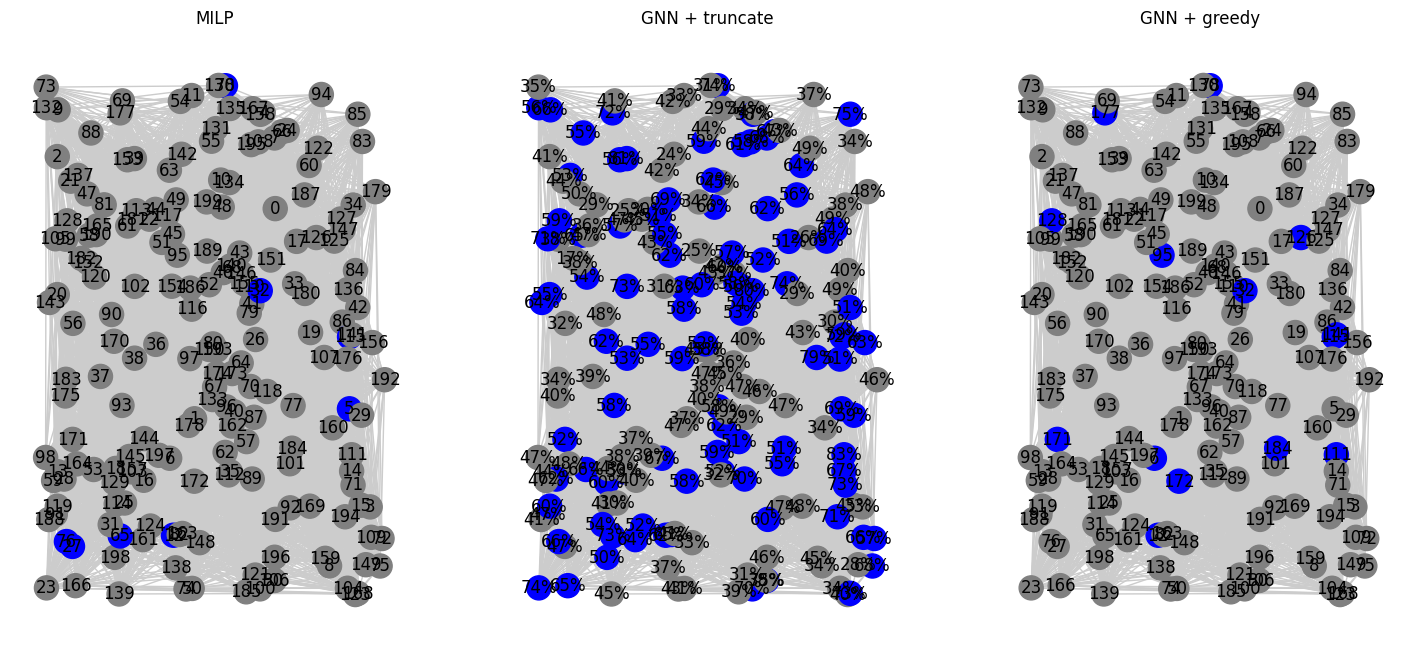

In [27]:
plt.ioff()

try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.random_layout(g_n)

fig, axes = plt.subplots(ncols=3, figsize=(18, 8))

node_colors = ['blue' if n in sol else 'gray' for n in g_n]
edge_color = (0.8, 0.8, 0.8)
nx.draw(g_n, with_labels=True, node_color=node_colors, edge_color=edge_color, pos=layout, ax=axes[0])

mvc_color = ['blue' if v else 'gray' for v in maps[id_best_sol].squeeze()]
node_colors = [mvc_color[n] for n in g_n]
label_dict = {n: f'{v*100:.0f}%' for n, v in sorted_prob_maps[id_best_sol]}
nx.draw(g_n, with_labels=True, node_color=node_colors, edge_color=edge_color, pos=layout, ax=axes[1], labels=label_dict)

mvc_color = ['blue' if v in s else 'gray' for v in range(n)]
node_colors = [mvc_color[n] for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, edge_color=edge_color, pos=layout, ax=axes[2])

for i, t in enumerate(['MILP', 'GNN + truncate', 'GNN + greedy']):
    axes[i].set_title(t)

plt.show()

In [28]:
# raise KeyError

# DS score output distribution

In [30]:
tt_g = 100
l = torch.nn.BCEWithLogitsLoss()
m = hyper_parameters['m']

results = [0] * m
gnn_ref_ltq_mvc = [False] * tt_g
gnn_ref_cv = [False] * tt_g  # if the solution is a vertex cover
cov_size_by_head = [0] * m
uncovered_nodes_by_head = [0] * m
indexes = set(range(len(graphs)))

for i in trange(tt_g):
    if graphs:
        tg = graphs[indexes.pop()]
        g = tg.edge_index
        mds = {i for i, s in enumerate(tg.y) if s}
    else:
        g = create_graph(n, p)
        mds = solver(g, n)

    x = get_x(g, n)
    g_n = nx.from_edgelist(g.T.tolist())
    g_n.x = x
    g_n.edge_list = g

    _, maps, idx = forward(gnn, g_n) # useful?

    cov_size, uncovered_nodes, idx = mdsi(maps, g)
    mds_index = cov_size + uncovered_nodes

    for j, m_i in enumerate(mds_index):
        if m_i <= mds_index[idx]:
            results[j] += 1

    s = mds_greedy(gnn, g_n)
    gnn_ref_ltq_mvc[i] = len(s) <= len(mds)
    gnn_ref_cv[i] = all(v in s or len(g_n[v].keys() & s) > 0 for v in g_n)

    cov_size, uncovered_nodes, _ = mdsi(maps, g)
    for head in range(m):
        cov_size_by_head[head] += cov_size[head].item()
        uncovered_nodes_by_head[head] += uncovered_nodes[head].item()

  0%|          | 0/100 [00:00<?, ?it/s]

0
120 1
1
31 2
168 3
3
3
3
3
3
102 4
80 5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
79 6
6
6
6
6
6
6
6
6
6
6
11 7
7
88 8
8
8
155 9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
156 10
10
10
93 11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
160 12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
0
129 1
17 2
2
42 3
3
3
3
3
126 4
4
4
4
4
4
4
4
4
0 5
57 6
6
6
6
6
6
102 7
7
7
7
7
7
7
7
7
7
7
119 8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
175 9
9
9
9
9
9
9
9
81 10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
198 11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11


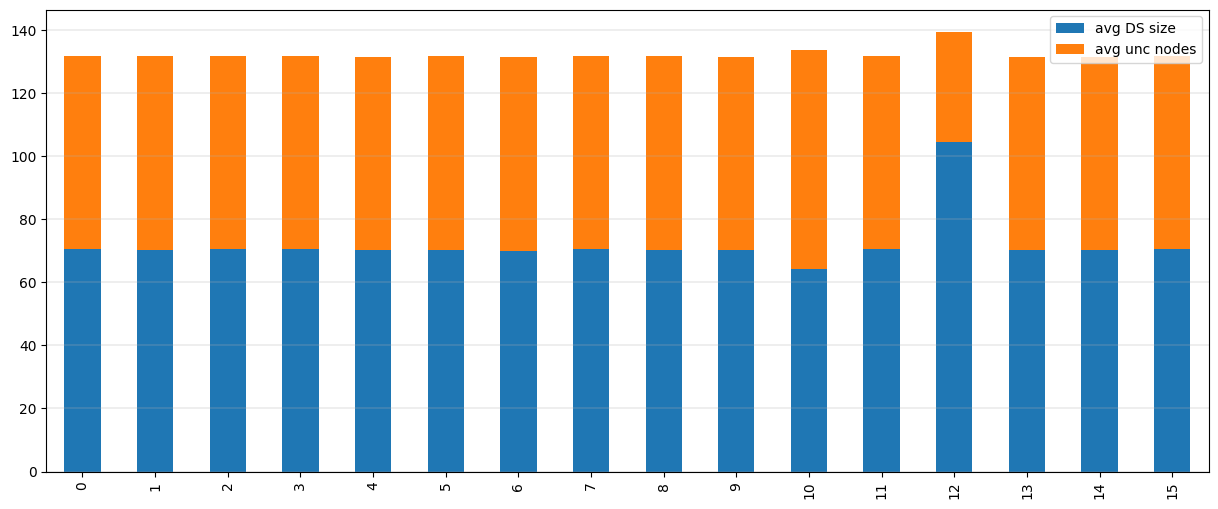

In [31]:
fig.clear()
ax = pd.DataFrame({
    'avg DS size': [s/tt_g for s in cov_size_by_head],
    'avg unc nodes': [s/tt_g for s in uncovered_nodes_by_head]
}).plot.bar(figsize=figsize, stacked=True)
ax.yaxis.grid(True, which='major', linewidth=.3)
plt.show()

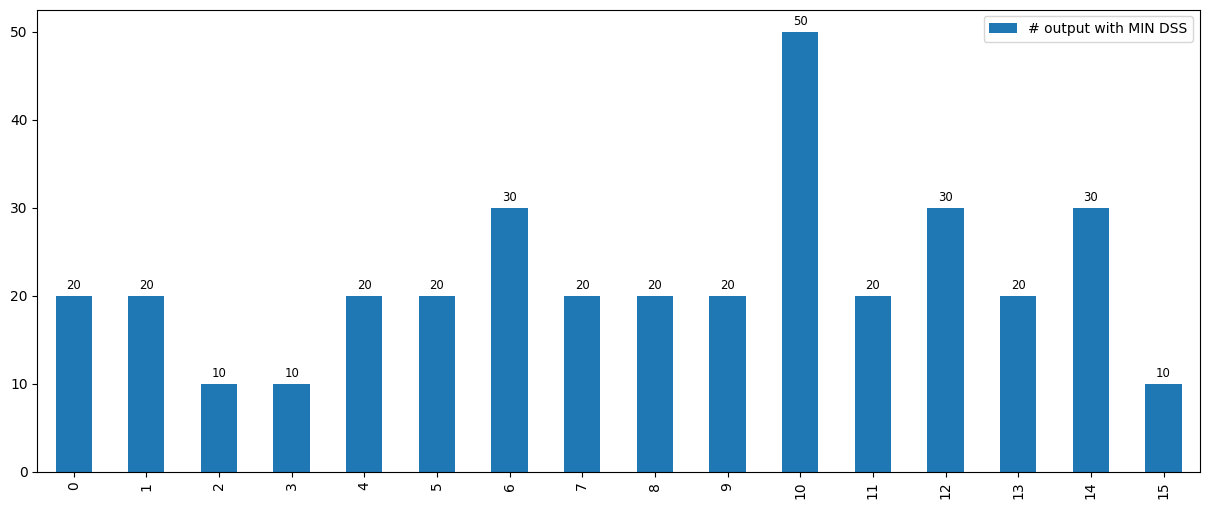

In [32]:
fig.clear()
ax = pd.DataFrame({
    '# output with MIN DSS': [r for r in results],
}).plot.bar(figsize=figsize)
ax.bar_label(ax.containers[0], labels=results, padding=3, size='small')
plt.show()

In [33]:
sum(gnn_ref_ltq_mvc)/tt_g, sum(gnn_ref_cv)/tt_g

(0.39, 1.0)

In [34]:
# raise Exception

# Recursive MDS

In [35]:
def tensor_pop(t, ids):
    if not isinstance(ids, Iterable):
        ids = [ids]

    index = t[:,0]
    mask = torch.tensor([i in ids for i in index])
    t[mask, 1:] = 0

    return t

def ei_remove_node(edge_index, node):
    mask = (edge_index[0] != node) & (edge_index[1] != node)
    new_edge_index = edge_index[:, mask]
    return new_edge_index

def remove_node(g: nx.Graph, n: int):
    g.remove_node(n)
    g.x = tensor_pop(g.x, n)
    g.edge_list = ei_remove_node(g.edge_list, n)
    return g

In [36]:
from pprint import pprint
def mds_r(gnn, g: nx.Graph, verbose=False):
    verb = verbose
    g_ = deepcopy(g)
    sorted_prob_maps, _, id_best_sol = forward(gnn, g_)
    s = set()
    n_s = set()

    if verb:
        print([(v, f'{p:.2f}') for v, p in sorted_prob_maps[id_best_sol]])
        print(g_.nodes,'\n', g.edge_list, f'\n{g.x=}')

    for v, p in sorted_prob_maps[id_best_sol]:
        if v in s | n_s:
            break
        if v not in g_:
            # this can happen in a recursive call because the input x is not resized
            # to avoid problems with the vector indices on the edge_index,
            # given that it keep vertex with index > len(x) if x was decreased.
            # it could be faster to remove the indices from X and ajust the edge_index
            # to avoid passing unecessary nodes to the network
            continue

        s.add(v)
        if verb: print(v, end=' ')
        for u in list(g_[v]):
            n_s.add(u)

        for u in list(g_[v]):
            # preventing lonely node after v removed
            # if len(g_[u]) == 1:
            #     g_ = remove_node(g_, u)
            if not g_[u].keys() - (s | n_s):
                g_ = remove_node(g_, u)

        g_ = remove_node(g_, v)

        if set(g_) <= n_s | s:
            break

    if not(set(g_) <= n_s | s):
        if verb: print('rec')
        for n, p in sorted_prob_maps[id_best_sol]:
            g_.x[n, 1] = p*10
        for n in list(g_):
            if not g_[n]:
                g_ = remove_node(g_, n)
        s |= mds_r(gnn, g_, verbose=verb)

    return s

In [38]:
if graphs:
    tg = choice(graphs)
    g = tg.edge_index
    sol = {i for i, s in enumerate(g_n.y) if s}
else:
    g = create_graph(n, p)
    sol = solver(g, n)
    y = torch.FloatTensor([[n in sol] for n in range(n)])

x = get_x(g, n)
g_n = nx.from_edgelist(g.T.tolist())
g_n.x = x
g_n.edge_list = g

s = mds_r(gnn, g_n)

print('\n', sol, s)
print(f'same size? {len(sol) == len(s)}')


 {2, 35, 132, 165, 197, 136, 9, 137, 107, 171, 52, 55, 24, 26, 127} {0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 187, 188, 189, 190, 191, 193, 194, 195, 197, 198}
same size? False


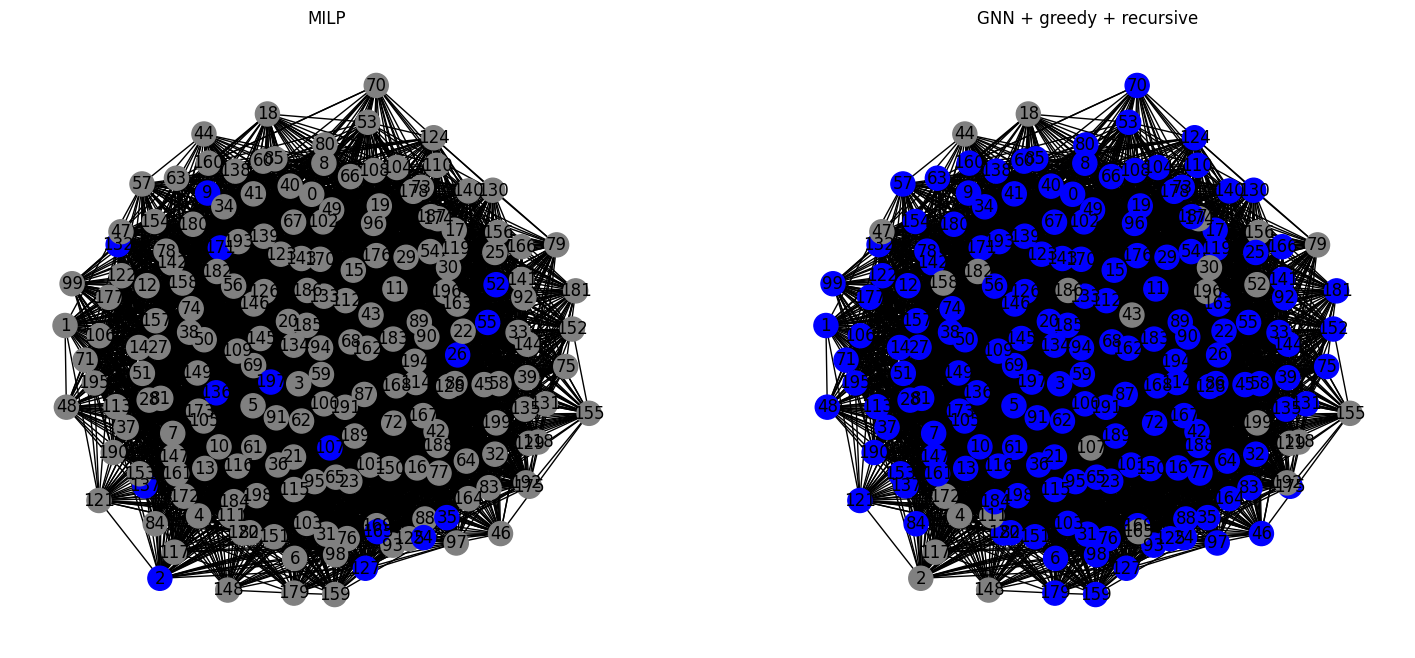

In [39]:
try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.spring_layout(g_n)

fig, axes = plt.subplots(ncols=2, figsize=(18, 8))

node_colors = ['blue' if n in sol else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[0])

node_colors = ['blue' if n in s else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[1])

for i, t in enumerate(['MILP', 'GNN + greedy + recursive']):
    axes[i].set_title(t)

plt.show()

In [40]:
# raise Exception

### Tree Search

In [41]:
def tree_search(gnn, g: nx.Graph, max_expansions=10):
    g.s = set()
    bag = [g]
    best = set(g.nodes)

    expansions = 0
    found_min_at = 0
    while expansions < max_expansions and bag:
        g_id = randint(0, len(bag)-1)
        g = bag.pop(g_id)
        prob_maps, _, _ = forward(gnn, g)

        for m in prob_maps:
            s = set()
            g_ = deepcopy(g)
            n_s = set()
            for v, _ in m:
                if v not in g_:
                    continue
                if v in s | n_s:
                    break

                s.add(v)
                for u in list(g_[v].keys()):
                    n_s.add(u)
                for u in list(g_[v]):
                    if not g_[u].keys() - (s | n_s):
                        g_ = remove_node(g_, u)

                g_ = remove_node(g_, v)

            new_mds = s | g_.s
            if not set(g_) - (new_mds | n_s):
                if len(new_mds) < len(best):
                    best = new_mds
                    found_min_at = expansions + 1
            else:
                g_.s = new_mds
                # TODO update g_.x and g_.edge_list
                bag.append(g_)

        expansions += 1

    return best, found_min_at

In [43]:
if graphs:
    tg = choice(graphs)
    g = tg.edge_index
    mds = {i for i, s in enumerate(g_n.y) if s}
else:
    g = create_graph(n, p)
    mds = solver(g, n)
    y = torch.FloatTensor([[n in mds] for n in range(n)])

x = get_x(g, n)
g_n = nx.from_edgelist(g.T.tolist())
g_n.x = x
g_n.edge_list = g

solution = tree_search(gnn, g_n)

mds, solution

({0, 17, 38, 41, 42, 86, 90, 102, 112, 121, 154, 163, 187},
 ({0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
  

## Methods Comparison

In [48]:
method_by_id = {0: mds_greedy, 1: mds_r, 2: tree_search}
# method_by_id = {2: tree_search}
valid_ds:    List[bool] = [[], [], []]
size_eq_mlip: List[bool] = [[], [], []]
avg_exp_to_find_min = 0

tt_g = 100
graphs_s = []
max_d = 0

print(f'sampling {tt_g} x G{n, p}')
indexes = set(range(len(graphs)))
for i in trange(tt_g):
    y = None
    if graphs:
        tg = graphs[indexes.pop()]
        g = tg.edge_index
        y = tg.y
    else:
        g = create_graph(n, p)
    x = get_x(g, n)
    g_n = nx.from_edgelist(g.T.tolist())
    g_n.x = x
    g_n.edge_list = g
    g_n.y = y
    if x[:,1].max() > max_d:
        max_d = x[:,1].max()
    graphs_s.append(g_n)

print(f'{max_d=}')
print(f'solving mds')
for g_n in tqdm(graphs_s):
    # g_n.x[:, 1] = g_n.x[:, 1]/max_d
    if g_n.y is not None:
        mds = {i for i, s in enumerate(g_n.y) if s}
    else:
        mds = solver(g_n.edge_list, n)

    for m_id, func in method_by_id.items():
        s = func(gnn, g_n)
        if isinstance(s, tuple):
            avg_exp_to_find_min += s[1]
            s = s[0]
        valid_ds[m_id].append(all(v in s or len(g_n[v].keys() & s) > 0 for v in g_n))
        size_eq_mlip[m_id].append(len(s) <= len(mds))

sampling 100 x G(200, 0.25)


  0%|          | 0/100 [00:00<?, ?it/s]

max_d=tensor(1.)
solving mds


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
graphs[8].x[:, 1]

In [49]:
for m_id, func in method_by_id.items():
    print(f'{func.__name__:<15} {100*sum(valid_ds[m_id])/tt_g}% valid DS      {100*sum(size_eq_mlip[m_id])/tt_g}% equivalent to MILP')

print(f'{" "*16}avg expansions to find DS {avg_exp_to_find_min/tt_g:.2f}')

mds_greedy      100.0% valid DS      39.0% equivalent to MILP
mds_r           100.0% valid DS      0.0% equivalent to MILP
tree_search     100.0% valid DS      0.0% equivalent to MILP
                avg expansions to find DS 0.00


In [ ]:
method_by_id = {0: mds_greedy, 1: mds_r, 2: tree_search}
valid_ds    = [[], [], []]
size_eq_mlip = [[], [], []]
avg_exp_to_find_min = 0

tt_g = 1000
n = 10
p = .25
for i in trange(tt_g):
    g = create_graph(n, p)
    x = get_x(g, n)
    g_n = nx.from_edgelist(g.T.tolist())
    g_n.x = x
    g_n.edge_list = g

    mds = solver(g, n)
    y = torch.FloatTensor([[n in mds] for n in range(n)])

    for m_id, func in method_by_id.items():
        s = func(gnn, g_n)
        if isinstance(s, tuple):
            avg_exp_to_find_min += s[1]
            s = s[0]
        valid_ds[m_id].append(all(v in s or len(g_n[v].keys() & s) > 0 in s for v in g_n))
        size_eq_mlip[m_id].append(len(s) <= len(mds))

for m_id, func in method_by_id.items():
    print(f'{func.__name__:<15} {100*sum(valid_ds[m_id])/tt_g}% valid DS      {100*sum(size_eq_mlip[m_id])/tt_g}% equivalent to MILP')

print(f'{" "*16}avg expansions to find DS {avg_exp_to_find_min/tt_g:.2f}')

In [ ]:
acc_mds_l = []
acc_mdsi_l = []
acc_mvc_l = []
acc_arg_max_l = []
forward_ids = []

tt_g = 1000
for i in trange(tt_g):
    idx_t = torch.Tensor([[i] for i in range(n)])
    x = torch.Tensor([[1.]]*n)
    x = torch.stack([idx_t, x], dim=1)
    g = create_graph(n, p)
    edge_list = [(int(a), int(b)) for a, b in g.T]
    g_n = nx.from_edgelist(edge_list)
    g_n.x = x
    g_n.edge_list = g

    mvc = milp_solve(deepcopy(g), n)
    mds = milp_solve_mds(deepcopy(g), n)

    _, maps, best_mdsi = forward(gnn, deepcopy(g_n))
    forward_ids.append(best_mdsi)

    mvc = torch.FloatTensor([[v in mvc] for v in range(n)])
    acc_mvc = ((maps == mvc).sum(dim=1) / y.size(dim=0)).max().item()
    mds = torch.FloatTensor([[v in mds] for v in range(n)])
    accs = (maps == mds).sum(dim=1) / y.size(dim=0)
    arg_max_accs = accs.argmax()
    acc_arg_max_l.append(arg_max_accs)
    acc_mds = accs.max().item()

    mds_i = maps[best_mdsi]
    acc_mdsi = (mds == mds_i).sum() / y.size(dim=0)

    acc_mds_l.append(acc_mds)
    acc_mvc_l.append(acc_mvc)
    acc_mdsi_l.append(acc_mdsi)

print(f'acc mvc: {sum(acc_mvc_l)/10000}        acc mds: {sum(acc_mds_l)/10000}      acc mds: {sum(acc_mdsi_l)/10000}')


In [ ]:
sum([i == j for i, j in zip(acc_arg_max_l, forward_ids)])/100

In [ ]:
list(zip(acc_arg_max_l, forward_ids))